# 13.8. 区域卷积神经网络（R-CNN）系列

**除了 13.7节中描述的单发多框检测之外， 区域卷积神经网络（region-based CNN或regions with CNN features，R-CNN） [Girshick et al., 2014]也是将深度模型应用于目标检测的开创性工作之一。 在本节中，我们将介绍R-CNN及其一系列改进方法：快速的R-CNN（Fast R-CNN） [Girshick, 2015]、更快的R-CNN（Faster R-CNN） [Ren et al., 2015]和掩码R-CNN（Mask R-CNN） [He et al., 2017]。 限于篇幅，我们只着重介绍这些模型的设计思路。**

## 13.8.1 R-CNN

**R-CNN首先从输入图像中选取若干（例如2000个）提议区域（如锚框也是一种选取方法），并标注它们的类别和边界框（如偏移量）。 [Girshick et al., 2014]然后，用卷积神经网络对每个提议区域进行前向传播以抽取其特征。 接下来，我们用每个提议区域的特征来预测类别和边界框。**


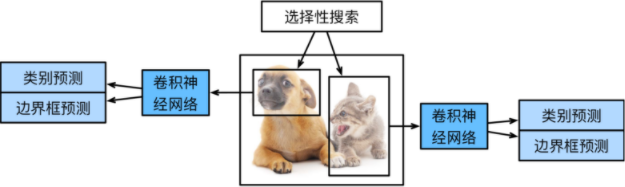

**图13.8.1展示了R-CNN模型。具体来说，R-CNN包括以下四个步骤：**

**1.对输入图像使用选择性搜索来选取多个高质量的提议区域 [Uijlings et al., 2013]。这些提议区域通常是在多个尺度下选取的，并具有不同的形状和大小。每个提议区域都将被标注类别和真实边界框。**

**2.选择一个预训练的卷积神经网络，并将其在输出层之前截断。将每个提议区域变形为网络需要的输入尺寸，并通过前向传播输出抽取的提议区域特征。**

**3.将每个提议区域的特征连同其标注的类别作为一个样本。训练多个支持向量机对目标分类，其中每个支持向量机用来判断样本是否属于某一个类别。**


**4.将每个提议区域的特征连同其标注的边界框作为一个样本，训练线性回归模型来预测真实边界框。**

**尽管R-CNN模型通过预训练的卷积神经网络有效地抽取了图像特征，但它的速度很慢。 想象一下，我们可能从一张图像中选出上千个提议区域，这需要上千次的卷积神经网络的前向传播来执行目标检测。 这种庞大的计算量使得R-CNN在现实世界中难以被广泛应用。**


## 13.8.2 Fast-RCNN

**R-CNN的主要性能瓶颈在于，对每个提议区域，卷积神经网络的前向传播是独立的，而没有共享计算。 由于这些区域通常有重叠，独立的特征抽取会导致重复的计算。 Fast R-CNN [Girshick, 2015]对R-CNN的主要改进之一，是仅在整张图象上执行卷积神经网络的前向传播。**

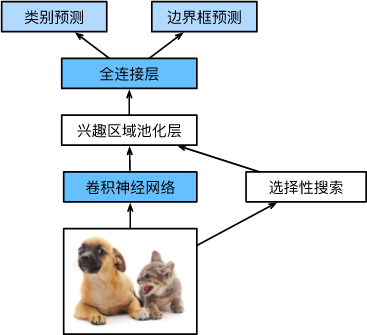

                                  图13.8.2 Fast-RCNN模型
                                  
                                  
 **图13.8.2中描述了Fast R-CNN模型。它的主要计算如下：**
 
 
**1.与R-CNN相比，Fast R-CNN用来提取特征的卷积神经网络的输入是整个图像，而不是各个提议区域。此外，这个网络通常会参与训练。设输入为一张图像，将卷积神经网络的输出的形状记为1×c×h1×w1。**

**2.假设选择性搜索生成了n个提议区域。这些形状各异的提议区域在卷积神经网络的输出上分别标出了形状各异的兴趣区域。然后，这些感兴趣的区域需要进一步抽取出形状相同的特征（比如指定高度h2和宽度w2），以便于连结后输出。为了实现这一目标，Fast R-CNN引入了兴趣区域汇聚层（RoI pooling）：将卷积神经网络的输出和提议区域作为输入，输出连结后的各个提议区域抽取的特征，形状为n×c×h2×w2。**

**3.通过全连接层将输出形状变换为n×d，其中超参数d取决于模型设计。**

**4.预测n个提议区域中每个区域的类别和边界框。更具体地说，在预测类别和边界框时，将全连接层的输出分别转换为形状为n×q（q是类别的数量）的输出和形状为n×4的输出。其中预测类别时使用softmax回归。**

**在Fast R-CNN中提出的兴趣区域汇聚层与 6.5节中介绍的汇聚层有所不同。在汇聚层中，我们通过设置汇聚窗口、填充和步幅的大小来间接控制输出形状。而兴趣区域汇聚层对每个区域的输出形状是可以直接指定的。**

**例如，指定每个区域输出的高和宽分别为h2和w2。 对于任何形状为h×w的兴趣区域窗口，该窗口将被划分为h2×w2子窗口网格，其中每个子窗口的大小约为(h/h2)×(w/w2)。 在实践中，任何子窗口的高度和宽度都应向上取整，其中的最大元素作为该子窗口的输出。 因此，兴趣区域汇聚层可从形状各异的兴趣区域中均抽取出形状相同的特征。**

**作为说明性示例， 图13.8.3中提到，在4×4的输入中，我们选取了左上角3×3的兴趣区域。 对于该兴趣区域，我们通过2×2的兴趣区域汇聚层得到一个2×2的输出。 请注意，四个划分后的子窗口中分别含有元素0、1、4、5（5最大）；2、6（6最大）；8、9（9最大）；以及10。**

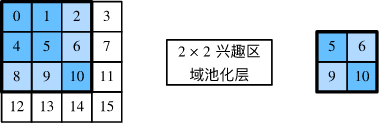


                 图13.8.3 一个  2×2  的兴趣区域汇聚层
                 
 **下面，我们演示了兴趣区域汇聚层的计算方法。 假设卷积神经网络抽取的特征X的高度和宽度都是4，且只有单通道**
 
                 
      




In [2]:
import paddle
import paddle.vision as paddlevision

X = paddle.reshape(paddle.arange(16, dtype='float32'), (1,1,4,4))
X

Tensor(shape=[1, 1, 4, 4], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [[[[0. , 1. , 2. , 3. ],
          [4. , 5. , 6. , 7. ],
          [8. , 9. , 10., 11.],
          [12., 13., 14., 15.]]]])

**让我们进一步假设输入图像的高度和宽度都是40像素，且选择性搜索在此图像上生成了两个提议区域。 每个区域由4个元素表示：左上角和右下角的 (x,y) 坐标。**

In [3]:
rois = paddle.to_tensor([[0, 0, 20, 20], [0, 10, 30, 30]]).astype('float32')
boxes_num = paddle.to_tensor([len(rois)]).astype('int32')

**由于X的高和宽是输入图像高和宽的 1/10 ，因此，两个提议区域的坐标先按spatial_scale乘以0.1。 然后，在X上分别标出这两个兴趣区域X[:, :, 1:4, 0:4]和X[:, :, 1:4, 0:4]。 最后，在 2×2 的兴趣区域汇聚层中，每个兴趣区域被划分为子窗口网格，并进一步抽取相同形状 2×2 的特征**

In [4]:
pool_out = paddlevision.ops.roi_pool(X, rois, boxes_num, output_size=(2,2), spatial_scale=0.1)
pool_out

Tensor(shape=[2, 1, 2, 2], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [[[[5. , 6. ],
          [9. , 10.]]],


        [[[9. , 11.],
          [13., 15.]]]])

## 13.8.3. Faster R-CNN
**为了较精确地检测目标结果，Fast R-CNN模型通常需要在选择性搜索中生成大量的提议区域。 Faster R-CNN [Ren et al., 2015]提出将选择性搜索替换为区域提议网络（region proposal network），从而减少提议区域的生成数量，并保证目标检测的精度。**


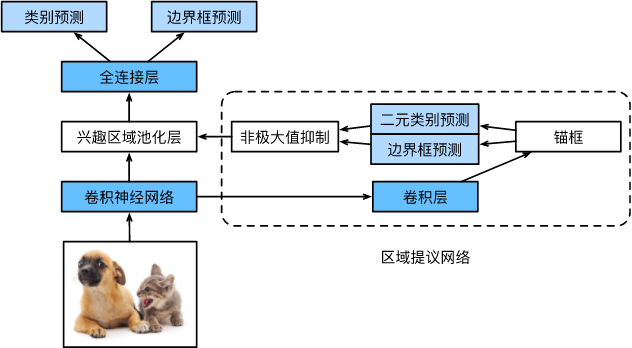

                         图13.8.4 Faster R-CNN 模型
**1.使用填充为1的 3×3 的卷积层变换卷积神经网络的输出，并将输出通道数记为 c 。这样，卷积神经网络为图像抽取的特征图中的每个单元均得到一个长度为 c 的新特征。**

**2.以特征图的每个像素为中心，生成多个不同大小和宽高比的锚框并标注它们。**

**3.使用锚框中心单元长度为 c 的特征，分别预测该锚框的二元类别（含目标还是背景）和边界框。**

**4.使用非极大值抑制，从预测类别为目标的预测边界框中移除相似的结果。最终输出的预测边界框即是兴趣区域汇聚层所需的提议区域。**

**值得一提的是，区域提议网络作为Faster R-CNN模型的一部分，是和整个模型一起训练得到的。 换句话说，Faster R-CNN的目标函数不仅包括目标检测中的类别和边界框预测，还包括区域提议网络中锚框的二元类别和边界框预测。 作为端到端训练的结果，区域提议网络能够学习到如何生成高质量的提议区域，从而在减少了从数据中学习的提议区域的数量的情况下，仍保持目标检测的精度。**

## 13.8.4. Mask R-CNN¶

**如果在训练集中还标注了每个目标在图像上的像素级位置，那么Mask R-CNN [He et al., 2017]能够有效地利用这些详尽的标注信息进一步提升目标检测的精度。**

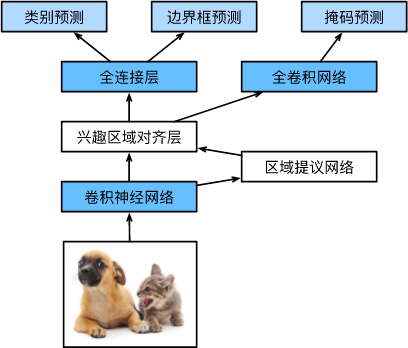


             图13.8.5 Mask R-CNN 模型¶
             
             
**如 图13.8.5所示，Mask R-CNN是基于Faster R-CNN修改而来的。 具体来说，Mask R-CNN将兴趣区域汇聚层替换为了 兴趣区域对齐层，使用双线性插值（bilinear interpolation）来保留特征图上的空间信息，从而更适于像素级预测。 兴趣区域对齐层的输出包含了所有与兴趣区域的形状相同的特征图。 它们不仅被用于预测每个兴趣区域的类别和边界框，还通过额外的全卷积网络预测目标的像素级位置。 本章的后续章节将更详细地介绍如何使用全卷积网络预测图像中像素级的语义。**   


## 13.8.5. 小结
**R-CNN对图像选取若干提议区域，使用卷积神经网络对每个提议区域执行前向传播以抽取其特征，然后再用这些特征来预测提议区域的类别和边界框。**

**Fast R-CNN对R-CNN的一个主要改进：只对整个图像做卷积神经网络的前向传播。它还引入了兴趣区域汇聚层，从而为具有不同形状的兴趣区域抽取相同形状的特征。**

**Faster R-CNN将Fast R-CNN中使用的选择性搜索替换为参与训练的区域提议网络，这样后者可以在减少提议区域数量的情况下仍保证目标检测的精度。**

**Mask R-CNN在Faster R-CNN的基础上引入了一个全卷积网络，从而借助目标的像素级位置进一步提升目标检测的精度。**

## 13.8.6. 练习
**我们能否将目标检测视为回归问题（例如预测边界框和类别的概率）？你可以参考YOLO模型 [Redmon et al., 2016]的设计。**

**将单发多框检测与本节介绍的方法进行比较。他们的主要区别是什么？你可以参考 [Zhao et al., 2019]中的图2。**